In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 10

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

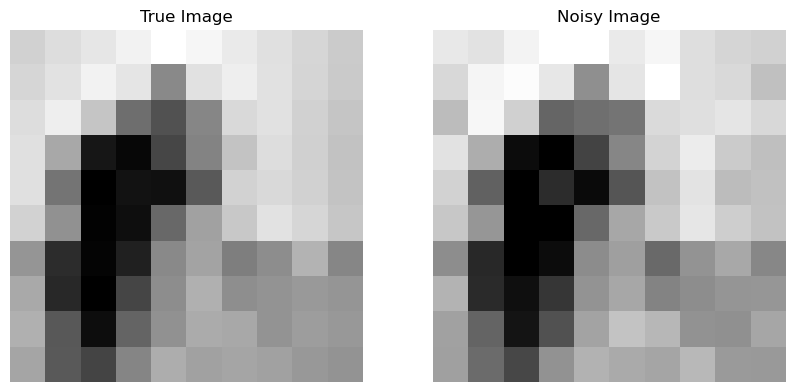

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=30, tol=1e-2,print_level=5)

b'Invalid number of indices returned from jacobian'


(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)
(100, 281)
(180, 281)


In [9]:
print(len(x_opt))
print(x_opt)

281
[ 8.94768830e-01  9.05065194e-01  9.54247783e-01  9.65089979e-01
  9.75377386e-01  9.16538126e-01  9.39874277e-01  8.68133016e-01
  8.36779669e-01  8.27569482e-01  8.62512395e-01  9.32250757e-01
  9.54659194e-01  9.05967252e-01  5.89570871e-01  8.91113373e-01
  9.63544191e-01  8.69731975e-01  8.38018164e-01  7.86189943e-01
  7.78051567e-01  9.16716660e-01  8.03335903e-01  4.20054210e-01
  4.33711870e-01  4.99860003e-01  8.50038582e-01  8.71688930e-01
  8.71557974e-01  8.36351261e-01  8.56439926e-01  6.81487900e-01
  7.76912186e-02  5.15473938e-02  2.59611031e-01  4.99492661e-01
  8.29653518e-01  8.96798739e-01  7.95316891e-01  7.63831276e-01
  8.05488502e-01  4.05758033e-01  3.74632566e-02  1.15628360e-01
  1.11908821e-01  3.68056577e-01  7.65271413e-01  8.62447604e-01
  7.61516561e-01  7.60958682e-01  7.55661318e-01  5.56936946e-01
  3.25695951e-02  3.26295592e-02  3.95771906e-01  6.27870363e-01
  7.61291111e-01  8.62491940e-01  7.92578283e-01  7.59303859e-01
  5.61383036e-01  1.8

In [10]:
N = scale**2
M = 2*scale*(scale-1)
u = x_opt[:N]
q = x_opt[N: N+M]
alpha = x_opt[N+M:]

In [11]:
print(alpha)

[0.01395166]


In [12]:
print(q)

[-0.00571019  0.00174494  0.00099793 -0.01386012  0.01172901  0.01005022
 -0.01086285  0.0136449   0.01200554  0.00296437  0.01392992 -0.00350823
 -0.0127296  -0.01384211 -0.01391593 -0.00159562 -0.00755509  0.00967688
 -0.00875488 -0.00290958  0.00710747  0.0136331  -0.00077871 -0.0135034 ]


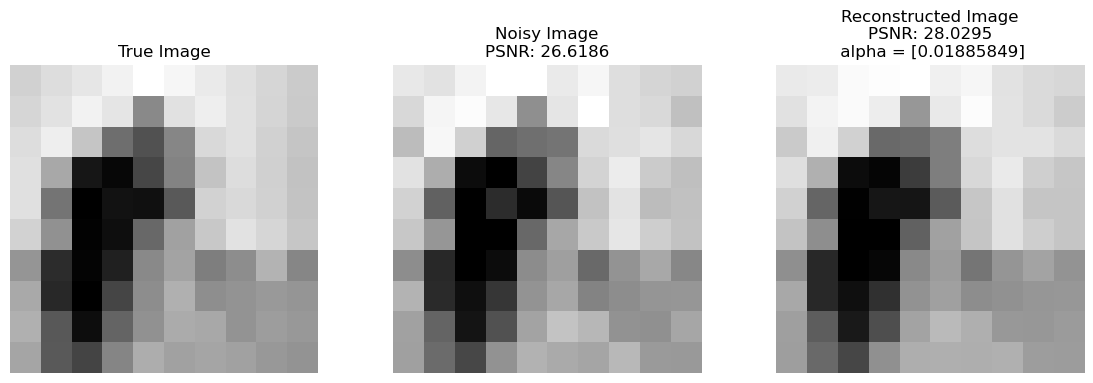

In [11]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)